In [4]:
import os
import sys
sys.path.append(os.path.abspath("../"))
from collections import defaultdict
from glob import glob
from tqdm.auto import tqdm
import trimesh
from pclib.visualization import plot_point_cloud
import numpy as np


# Collect data files

In [5]:
data_path = "../data"
categories = ["chair", "table"]

In [6]:
file_paths = defaultdict(list)

for category in tqdm(categories):
    category_files = glob(os.path.join(data_path, category, "*"))

    file_paths[category] = list(category_files)

  0%|          | 0/2 [00:00<?, ?it/s]

# Understanding the Point Cloud Class

In [4]:
table_sample = trimesh.load(file_paths["table"][0])
chair_sample = trimesh.load(file_paths["chair"][0])

## Visualizing Them

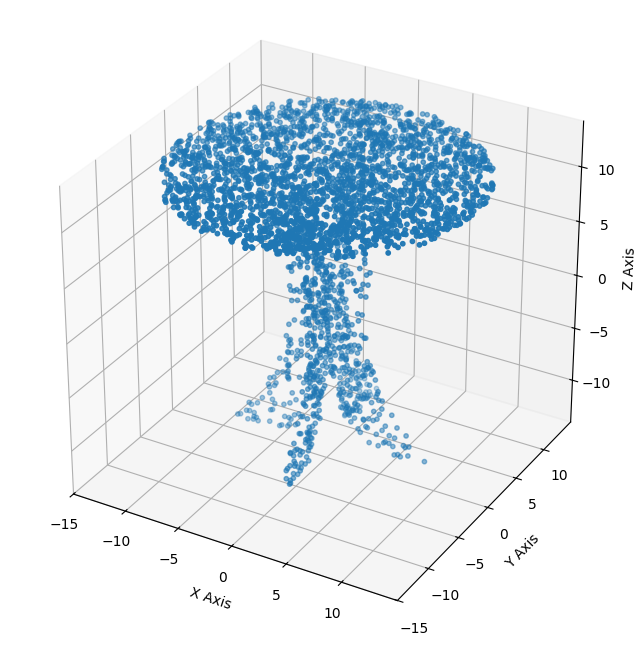

In [5]:
plot_point_cloud(table_sample)

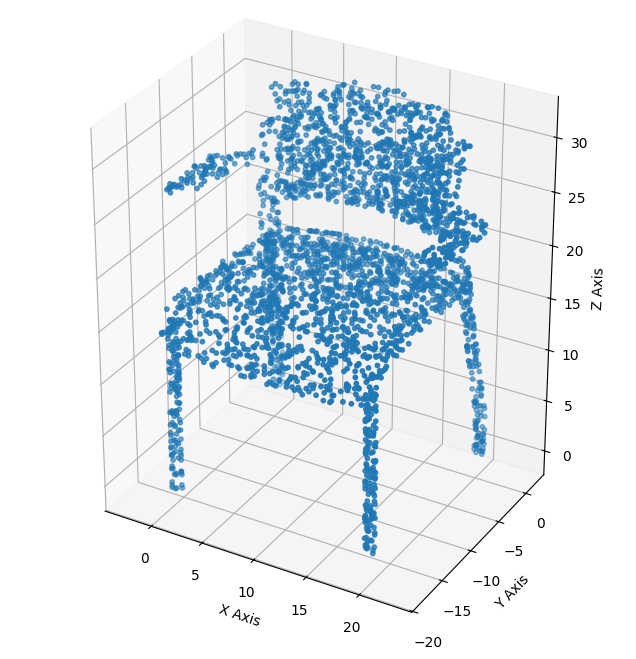

In [6]:

plot_point_cloud(chair_sample)

In [7]:
import inspect
print("Attributes:", [m for m in dir(trimesh.PointCloud) if not callable(getattr(trimesh.PointCloud, m))])
print("Methods:", [m for m in dir(trimesh.PointCloud) if callable(getattr(trimesh.PointCloud, m))])

Attributes: ['__abstractmethods__', '__annotations__', '__dict__', '__doc__', '__module__', '__slots__', '__weakref__', '_abc_impl', 'bounding_box', 'bounding_box_oriented', 'bounding_cylinder', 'bounding_primitive', 'bounding_sphere', 'bounds', 'centroid', 'colors', 'convex_hull', 'extents', 'identifier', 'identifier_hash', 'is_empty', 'kdtree', 'moment_inertia', 'scale', 'shape', 'source', 'units', 'vertices', 'weights']
Methods: ['__add__', '__class__', '__delattr__', '__dir__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'apply_obb', 'apply_scale', 'apply_transform', 'apply_translation', 'copy', 'export', 'hash', 'merge_vertices', 'query', 'scene', 'show']


In [8]:
table_sample.kdtree # cannot use all methods

ModuleNotFoundError: No module named 'scipy'

In [7]:
chair_sample.vertices.mean(axis=0)

TrackedArray([10.20726609, -6.34857675, 19.06078739])

# Testing out Transforms

In [7]:
from pclib.datasets import load_dataset
import pclib.datasets.data_transforms as transforms

In [8]:
dataset = load_dataset(data_path, categories, dataset_type="transforms")
dataset._file_paths[::100]
dataset

In [27]:
T0 = transforms.AffineTransfor3D(method="random")
T1 = transforms.Normalize()
T2 = transforms.DownSample(method="voxel", voxel_size=[0.1, 0.1, 0.1])
T3 = transforms.UniformSizedEmbedding(method="random", n_points=1000)

dataset.set_transforms([T1, T2])

data, label = dataset[0]
N, d = data.shape
N, d

(2180, 3)

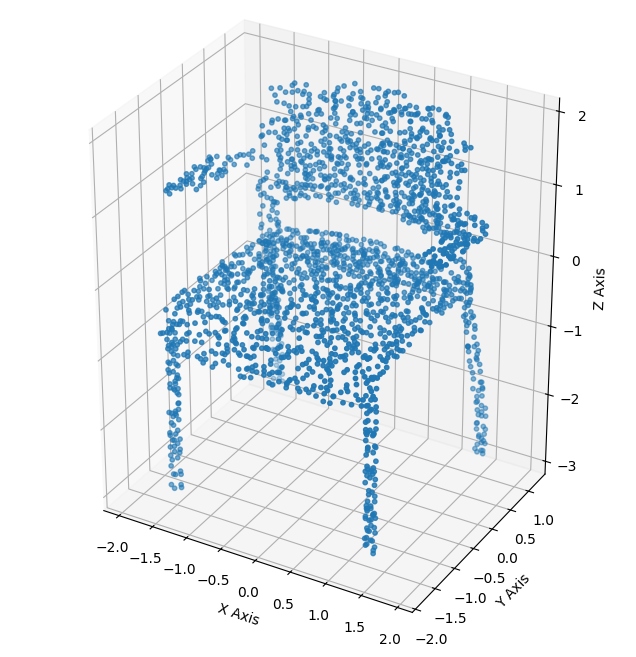

In [28]:
plot_point_cloud(data)

In [26]:
padding = np.zeros((1000 - 49, 3))
np.vstack([data, padding]).shape

(1000, 3)

In [ ]:
dataset.set_transforms([T])

In [13]:
dataset.transforms

In [14]:
data, label = dataset[7]

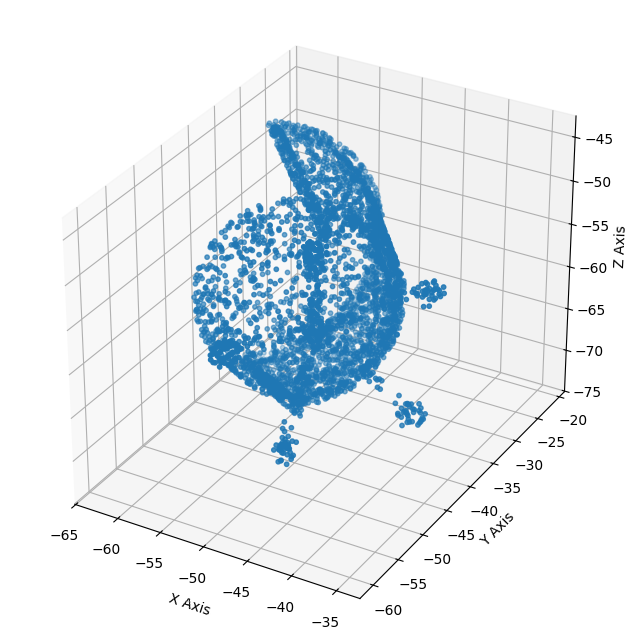

In [15]:
plot_point_cloud(data)

# Statistics

In [ ]:
chair_count = len(file_paths["chair"])
table_count = len(file_paths["table"])

chair_count, table_count




(989, 492)

In [17]:
point_cloud_size_sum = 0
point_cloud_size_count = chair_count + table_count

for category, category_file_paths in tqdm(file_paths.items()):
    for file_path in tqdm(category_file_paths, desc=category):
        point_cloud_size_sum += trimesh.load(file_path).vertices.shape[0]

point_cloud_average_size = point_cloud_size_sum / point_cloud_size_count
point_cloud_average_size

  0%|          | 0/2 [00:00<?, ?it/s]

chair:   0%|          | 0/989 [00:00<?, ?it/s]

table:   0%|          | 0/492 [00:00<?, ?it/s]

7464.303173531398

In [20]:
file_paths['chair'][::100]

['../data/chair/chair_0900.ply',
 '../data/chair/chair_0136.ply',
 '../data/chair/chair_0939.ply',
 '../data/chair/chair_0624.ply',
 '../data/chair/chair_0961.ply',
 '../data/chair/chair_0147.ply',
 '../data/chair/chair_0564.ply',
 '../data/chair/chair_0789.ply',
 '../data/chair/chair_0471.ply',
 '../data/chair/chair_0648.ply']

# Scratch Work

## Figuring out voxel desampling

Took some thinking but my approach to voxel desampling, inspired by this article: 

- https://medium.com/@lathwath5/point-cloud-downsampling-methods-and-python-implementations-6f91a129ac48

was to divide by voxel size to get "indexes" of each voxel position, i.e. which (x,y,z) coordinate box each point is in. Then, from each box, select only one point

In [41]:
chair_sample

vertices = np.array(chair_sample.vertices)

vertices

array([[ 8.74622440e+00, -1.78426723e+01,  1.74797668e+01],
       [ 1.34130335e+01, -9.62993050e+00,  1.85277328e+01],
       [ 3.53555632e+00, -1.76922703e+00,  2.70435505e+01],
       ...,
       [ 2.01685295e+01, -2.21551880e-02,  1.77498794e+00],
       [ 9.40784168e+00, -1.28239536e+00,  2.63315182e+01],
       [ 8.47853565e+00, -1.82575455e+01,  1.45776472e+01]],
      shape=(3352, 3))

In [51]:
vnorm = (vertices - vertices.mean(axis=0)) / vertices.std(axis=0)

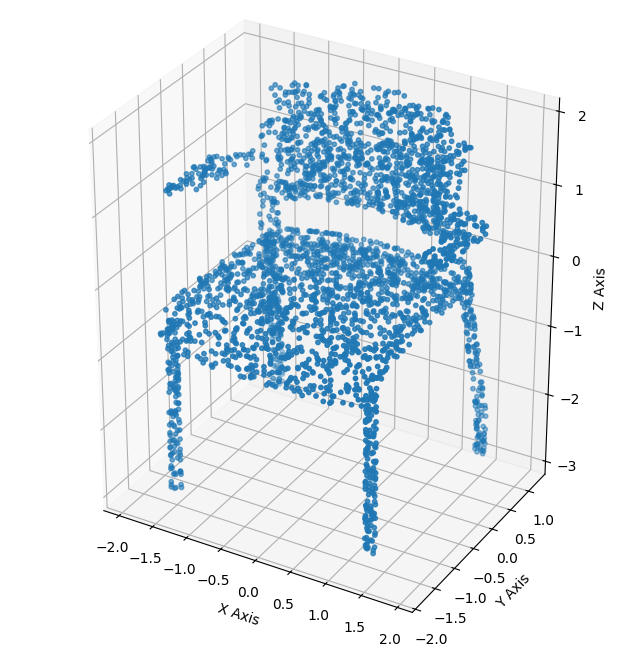

In [52]:
plot_point_cloud(vnorm)

In [ ]:
vnorm.max

array([[-0.21987335, -1.73005725, -0.23517779],
       [ 0.48243854, -0.49389965, -0.07929219],
       [-1.00403102,  0.68927017,  1.18744097],
       ...,
       [ 1.49907862,  0.95223425, -2.57127341],
       [-0.12030603,  0.76254663,  1.08152572],
       [-0.26015805, -1.79250272, -0.66686989]], shape=(3352, 3))

In [66]:
voxel_size = np.array([0.1, 0.1, 0.1])

In [67]:
coords = np.floor(vnorm / voxel_size)

In [68]:
coords

array([[ -3., -18.,  -3.],
       [  4.,  -5.,  -1.],
       [-11.,   6.,  11.],
       ...,
       [ 14.,   9., -26.],
       [ -2.,   7.,  10.],
       [ -3., -18.,  -7.]], shape=(3352, 3))

In [80]:
#coords[coords == [-20., -10., 9.]]
# https://stackoverflow.com/questions/25823608/find-matching-rows-in-2-dimensional-numpy-array

a, b = np.where((coords == (-20., -10., 9.)))#.all(axis=1)

In [92]:
np.unique(coords, axis=0).shape

(2180, 3)

In [93]:
coords.shape

(3352, 3)

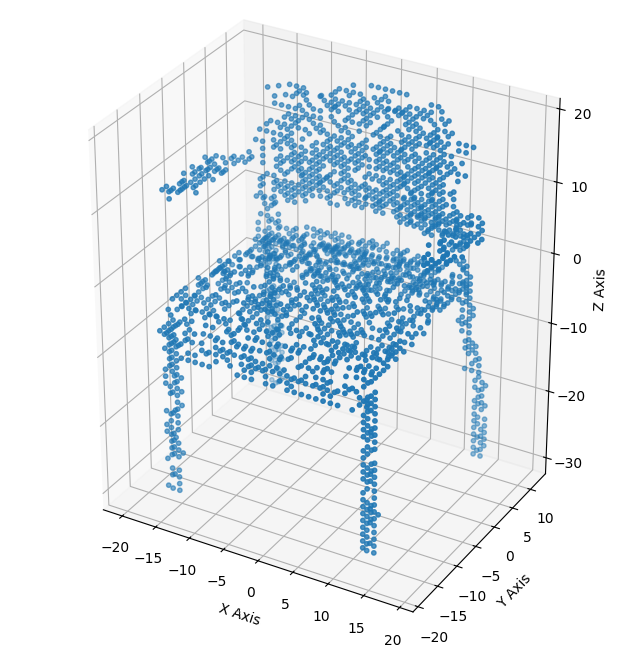

In [94]:
plot_point_cloud(np.unique(coords, axis=0))

In [100]:
unique_coords, indices = np.unique(coords, axis=0, return_index=True)


np.allclose(unique_coords, coords[indices]), (unique_coords == np.unique(coords, axis=0)).all()

(True, np.True_)

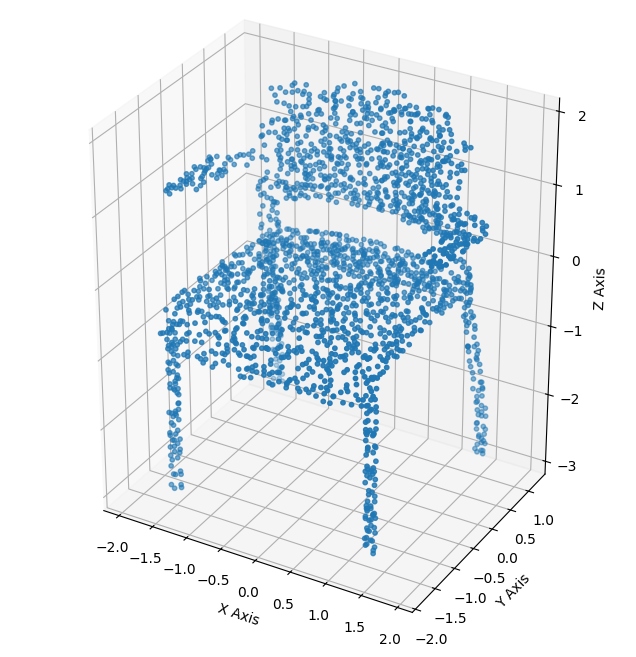

In [103]:
plot_point_cloud(vnorm[indices])

True